In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score
import ssl
import certifi
import urllib.request

import warnings
warnings.filterwarnings('ignore')

# Data preparation

In [36]:
file_path = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/GkDzb7bWrtvGXdPOfk6CIg/Obesity-level-prediction-dataset.csv"
ssl_context = ssl.create_default_context(cafile=certifi.where())
with urllib.request.urlopen(file_path, context=ssl_context) as response:
    data = pd.read_csv(response)
data

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


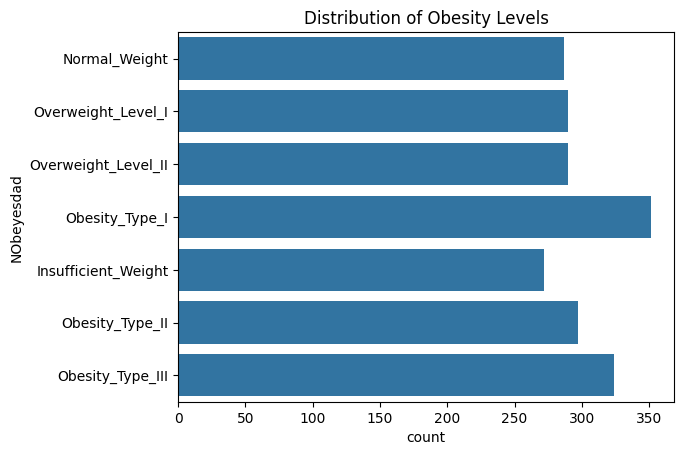

In [37]:
# Visualize the distribution of the target variable to understand the class balance.
# Distribution of target variable
sns.countplot(y='NObeyesdad', data=data)
plt.title('Distribution of Obesity Levels')
plt.show()

In [38]:
# Checking for null values
print("Null Values in Dataset:")
print(data.isnull().sum())

# Dataset summary
print("Dataset Summary:")
print(data.info())
print(data.describe())

Null Values in Dataset:
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64
Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 no

### Feature scaling

Scale the numerical features to standardize their ranges for better model performance. Standardization of data is important to better define the decision boundaries between classes by making sure that the feature variations are in similar scales. The data is now ready to be used for training and testing.

In [39]:
# Standardizing continuous numerical features
continuous_columns = data.select_dtypes(include=['float64']).columns.tolist()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[continuous_columns])

# Converting to a DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=scaler.get_feature_names_out(continuous_columns))

# Combining with the original dataset
scaled_data = pd.concat([data.drop(columns=continuous_columns), scaled_df], axis=1)

### One-hot encoding
Convert categorical variables into numerical format using one-hot encoding. You will observe that all the categorical variables have now been modified to one-hot encoded features. This increases the overall number of fields to 24.

In [40]:
# Identifying categorical columns
categorical_columns = scaled_data.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('NObeyesdad')  # Exclude target column

# Applying one-hot encoding
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = encoder.fit_transform(scaled_data[categorical_columns])

# Converting to a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

# Combining with the original dataset
prepped_data = pd.concat([scaled_data.drop(columns=categorical_columns), encoded_df], axis=1)

In [41]:
# Encode the target variable
prepped_data['NObeyesdad'] = prepped_data['NObeyesdad'].astype('category').cat.codes
prepped_data.head()

,NObeyesdad,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,1,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,5,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,6,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [42]:
# Preparing final dataset
X = prepped_data.drop('NObeyesdad', axis=1)
y = prepped_data['NObeyesdad']

# Model training and evaluation

In [43]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Logistic Regression with One-vs-All
In the One-vs-All approach:

* The algorithm trains a single binary classifier for each class.
* Each classifier learns to distinguish a single class from all the others combined.
* If there are k classes, k classifiers are trained.
* During prediction, the algorithm evaluates all classifiers on each input, and selects the class with the highest confidence score as the predicted class.

#### Advantages:
* Simpler and more efficient in terms of the number of classifiers (k)
* Easier to implement for algorithms that naturally provide confidence scores (e.g., logistic regression, SVM).

#### Disadvantages:
* Classifiers may struggle with class imbalance since each binary classifier must distinguish between one class and the rest.
* Requires the classifier to perform well even with highly imbalanced datasets, as the "all" group typically contains more samples than the "one" class.


In [44]:
# Training logistic regression model using One-vs-All (default)
model_ova = LogisticRegression(multi_class='ovr', max_iter=1000)
model_ova.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'ovr'


In [45]:
# You can now evaluate the accuracy of the trained model as a measure of its performance on unseen testing data.
# Predictions
y_pred_ova = model_ova.predict(X_test)

# Evaluation metrics for OvA
print("One-vs-All (OvA) Strategy")
print(f"Accuracy: {np.round(100*accuracy_score(y_test, y_pred_ova),2)}%")

One-vs-All (OvA) Strategy
Accuracy: 76.12%


### Logistic Regression with OvO

In the One-vs-One approach:
* The algorithm trains a binary classifier for every pair of classes in the dataset.
* If there are k classes, this results in $k(k-1)/2$ classifiers.
* Each classifier is trained to distinguish between two specific classes, ignoring the rest.
* During prediction, all classifiers are used, and a "voting" mechanism decides the final class by selecting the class that wins the majority of pairwise comparisons.

#### Advantages:
* Suitable for algorithms that are computationally expensive to train on many samples because each binary classifier deals with a smaller dataset (only samples from two classes).
* Can be more accurate in some cases since classifiers focus on distinguishing between two specific classes at a time.

#### Disadvantages:
* Computationally expensive for datasets with a large number of classes due to the large number of classifiers required.
* May lead to ambiguous predictions if voting results in a tie.


In [46]:
# Training logistic regression model using One-vs-One
model_ovo = OneVsOneClassifier(LogisticRegression(max_iter=1000))
model_ovo.fit(X_train, y_train)

,estimator,LogisticRegre...max_iter=1000)
,n_jobs,None
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'


In [47]:
# Predictions
y_pred_ovo = model_ovo.predict(X_test)

# Evaluation metrics for OvO
print("One-vs-One (OvO) Strategy")
print(f"Accuracy: {np.round(100*accuracy_score(y_test, y_pred_ovo),2)}%")

One-vs-One (OvO) Strategy
Accuracy: 92.2%


# Exercises

Q1. Experiment with different test sizes in the train_test_split method (e.g., 0.1, 0.3) and observe the impact on model performance.

In [48]:
for test_size in [0.1, 0.3]:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
  model_ova.fit(X_train, y_train)
  y_pred = model_ova.predict(X_test)
  print("One-vs-All (OvA) Strategy")
  print(f"Accuracy: {np.round(100*accuracy_score(y_test, y_pred),2)}%")

One-vs-All (OvA) Strategy
Accuracy: 75.94%
One-vs-All (OvA) Strategy
Accuracy: 74.92%


Q2. Plot a bar chart of feature importance using the coefficients from the One vs All logistic regression model. Also try for the One vs One model.

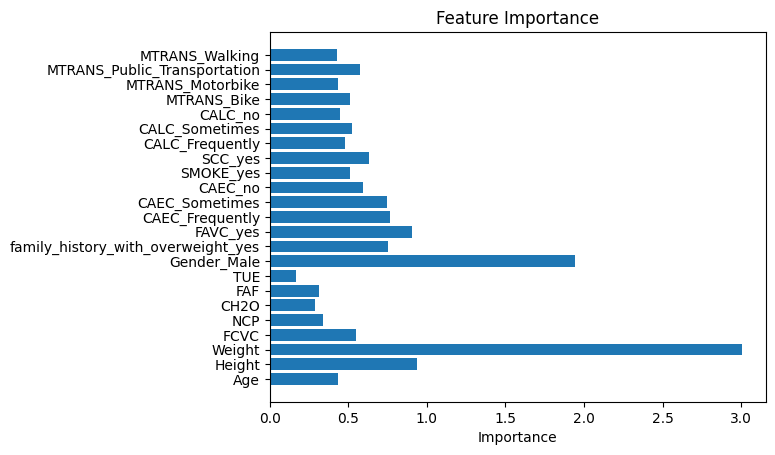

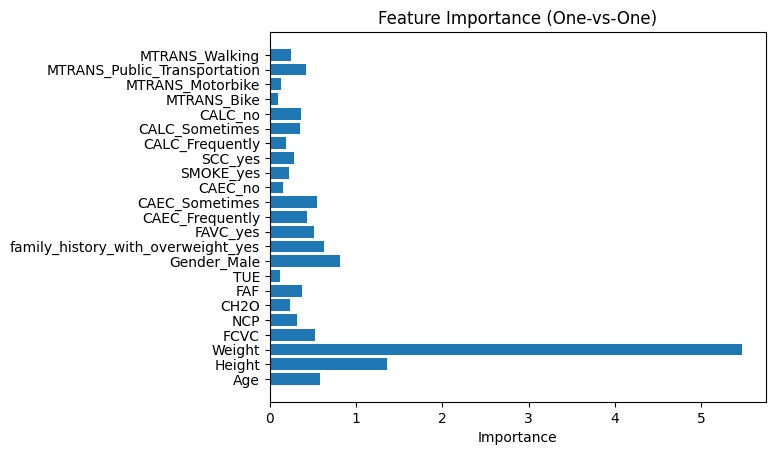

In [49]:
# Feature importance
feature_importance = np.mean(np.abs(model_ova.coef_), axis=0)
plt.barh(X.columns, feature_importance)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.show()

# For One vs One model
# Collect all coefficients from each underlying binary classifier
coefs = np.array([est.coef_[0] for est in model_ovo.estimators_])

# Now take the mean across all those classifiers
feature_importance = np.mean(np.abs(coefs), axis=0)

# Plot feature importance
plt.barh(X.columns, feature_importance)
plt.title("Feature Importance (One-vs-One)")
plt.xlabel("Importance")
plt.show()

Q3. Write a function obesity_risk_pipeline to automate the entire pipeline:

Loading and preprocessing the data
Training the model
Evaluating the model
The function should accept the file path and test set size as the input arguments.

In [54]:
# def obesity_risk_pipeline(data_path, test_size=0.2):
#     # Load data
#     with urllib.request.urlopen(data_path, context=ssl_context) as response:
#       data = pd.read_csv(data_path)

# Standardizing continuous numerical features
continuous_columns = data.select_dtypes(include=['float64']).columns.tolist()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[continuous_columns])

# Converting to a DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=scaler.get_feature_names_out(continuous_columns))

# Combining with the original dataset
scaled_data = pd.concat([data.drop(columns=continuous_columns), scaled_df], axis=1)

# Identifying categorical columns
categorical_columns = scaled_data.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('NObeyesdad')  # Exclude target column

# Applying one-hot encoding
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = encoder.fit_transform(scaled_data[categorical_columns])

# Converting to a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

# Combining with the original dataset
prepped_data = pd.concat([scaled_data.drop(columns=categorical_columns), encoded_df], axis=1)

# Encoding the target variable
prepped_data['NObeyesdad'] = prepped_data['NObeyesdad'].astype('category').cat.codes

# Preparing final dataset
X = prepped_data.drop('NObeyesdad', axis=1)
y = prepped_data['NObeyesdad']

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

# Training and evaluation
model = LogisticRegression(multi_class='multinomial', max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

# # Call the pipeline function with file_path
# obesity_risk_pipeline(file_path, test_size=0.2)

Accuracy: 0.8675078864353313
